Low maintanence arsenal for our quest.

In [114]:
%matplotlib inline
import pandas as pd
import numpy as np

#no warnings because I like my stuff clean.
import warnings
warnings.filterwarnings('ignore')

#pipemaster
from sklearn.pipeline import Pipeline

Load the training and test data.

In [115]:
train = pd.read_csv('data/Train.csv')
test =  pd.read_csv('data/test.csv')

***EDA***

Size

In [116]:
train.shape

(401125, 53)

What do you have there?

In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

Sad, a lot of these columns have significant amounts of missing data.

We will need to deal with those, one way or another. However I want to create an initial basic model in order to observe the model improvement through feature engineering.

Following code creates a new data frame with the columns that have absolutely none null values. 

In [118]:
# get the column counts with applying .count() to each row(axis=0)
column_counts = train.apply(lambda x: x.count(), axis=0) 
#decide on which columns to keep(only the columns with maximum column count)
keep_columns = column_counts[column_counts == column_counts.max()]
# create the dataframe
dense_train = train.loc[:,keep_columns.index]
dense_train.shape

(401125, 13)

Looks like there are only 13 columns without missing values. eh not bad for early stage.

In [119]:
dense_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 13 columns):
SalesID               401125 non-null int64
SalePrice             401125 non-null int64
MachineID             401125 non-null int64
ModelID               401125 non-null int64
datasource            401125 non-null int64
YearMade              401125 non-null int64
saledate              401125 non-null object
fiModelDesc           401125 non-null object
fiBaseModel           401125 non-null object
fiProductClassDesc    401125 non-null object
state                 401125 non-null object
ProductGroup          401125 non-null object
ProductGroupDesc      401125 non-null object
dtypes: int64(6), object(7)
memory usage: 39.8+ MB


salesid, machineid and modelid are integers. Notable problem for our model.

Following code changes type of the mentioned columns on the dataset to string.

In [120]:
id_cols = ['SalesID', 'MachineID', 'ModelID']
dense_train[id_cols] = dense_train[id_cols].astype('str', inplace=True)
print(type(dense_train.SalesID[0]))
print(type(dense_train['MachineID'][0]))
print(type(dense_train.ModelID[0]))

<class 'str'>
<class 'str'>
<class 'str'>


In [121]:
dense_train.describe()

,SalePrice,datasource,YearMade
count,401125.000000,401125.000000,401125.000000
mean,31099.712848,134.665810,1899.156901
std,23036.898502,8.962237,291.797469
min,4750.000000,121.000000,1000.000000
25%,14500.000000,132.000000,1985.000000
50%,24000.000000,132.000000,1995.000000
75%,40000.000000,136.000000,2000.000000
max,142000.000000,172.000000,2013.000000


Minimum value of YearMade is 1000. I don't Tracktors were invented back then. Lets have a closer look.

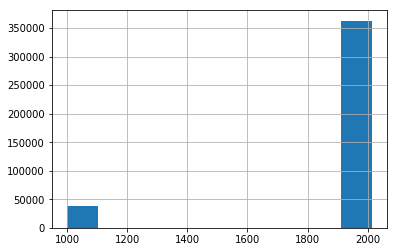

In [122]:
dense_train.YearMade.hist();

In [123]:
dense_train.YearMade.value_counts().head()

1000    38185
1998    21221
2005    20587
2004    20020
1997    18905
Name: YearMade, dtype: int64

Alright we have 38185 tracktors that is made in year 1000 in ourdataset, a significant group of outliers. I assume these are missing values and there are a couple of ways to deal with missing values.

Options:
- if outliers accounts for a small measure of our data, we can simply drop them.
- we can fill them with mode,median, mean, max or min depending on the data.
- we can create an algoritm to predict missing values, which is a complete new project at this stage.

get the ratio:

In [124]:
(dense_train.YearMade.value_counts() / dense_train.YearMade.count()).head()

1000    0.095195
1998    0.052904
2005    0.051323
2004    0.049910
1997    0.047130
Name: YearMade, dtype: float64

YearMade: 1000 stands for almost 10% of our data. I am not giving up on that.

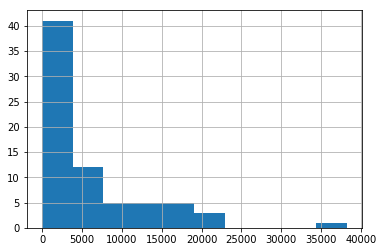

In [125]:
dense_train.YearMade.value_counts().hist()

Lets calculate mean median and mode to see which one makes more sense to replace missing values.

In [126]:
print(f'mean: {dense_train.YearMade.mean()}')
print(f'mode: {dense_train.YearMade.mode()}')
print(f'median: {dense_train.YearMade.median()}')

mean: 1899.1569012153318
mode: 0    1000
dtype: int64
median: 1995.0


Hmm I think I will go with the mean because it better represents the dataset.

**AHA! Tricked you!** If we simply run analisis on the pure data with given condition we include 38000 missing(wrong) values in our calculations.

Solution: Set a condition before runnin calculations. Lets just considers tracktors that are made after year 1900( I decided to keep the number a little low because who knows, maybe some people buy very old tracktors for collection purposes, weird hobby eh? But who am I to judge...)

In [127]:
condition = dense_train.YearMade > 1900
mean = dense_train.YearMade[condition].mean()
mode = dense_train.YearMade[condition].mode()
median = dense_train.YearMade[condition].median()


print(f'mean: {mean}')
print(f'mode: {mode}')
print(f'median: {median}')

mean: 1993.7574034275638
mode: 0    1998
dtype: int64
median: 1996.0


Alright all these years are close to each other so I will simply go with the median which in between max and min.

In [128]:
dense_train.loc[~condition, 'YearMade'] = int(median)

In [129]:
dense_train.YearMade.value_counts().head()

1996    54876
1998    21221
2005    20587
2004    20020
1997    18905
Name: YearMade, dtype: int64

## Dependent Variable(target - y)

Lets have a look at this one.

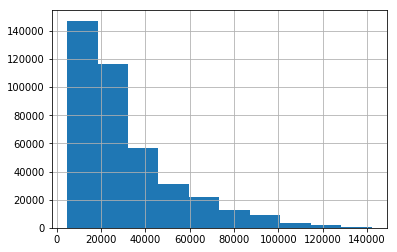

In [130]:
dense_train.SalePrice.hist()

This picture is a little bit surprising, it looks more like an exponential distribution than anything else. We might expect a more normal distribution for any given vehicle, but evidently our data set is so full of different types of vehicles that we get this shape. There are also apparently a lot of low-priced vehicles.

Since our RMSLE error metric penalizes underpredictions, we'll want to make sure that we do well on the right tail of this distribution and don't just focus on the common vehicles.

### Basic Model

We've taken care of some outlier values in the model year, but let's step back and talk about why.

Since we're talking about used equipment here, there are a few things that I believe matter to the price. If I were to rank them I would list them from most to least important as:

based on common sense

- What is a reasonable price for this vehicle? We don't have any columns in our data that tell us this, but the idea is that there are probably very different prices paid for more or less expensive pieces of equipment. If I knew what original cost of the vehicles was, this, along with the age would probably help me. As it is, I can probably get a estimate of the price by taking an average of similar vehicles sold recently. What the best notion of similar should be is unclear... so we may want to experiement in this regard.


- The age of the vehicle. Surely older vehicles cost less than newer ones right? We have the model year, but we'll need to compute the age on the date of sale for best results.


- How heavily used the vehicle is. Surely more heavily used vehicles are less expensive. Unfortunately there are a lot of missing values in the machinehoursusage. Let's investigate.

As we discover things that are relevant we will include them in our more rigorous model file in heavy_equipment_model.py. That's where will ultimately do cross validation and use pipelining to assure that our model works on unseen data.

**machine hours**

In [131]:
mhcm = train.MachineHoursCurrentMeter
print((mhcm == 0).sum(), ' zero values')
print(mhcm.isnull().sum(), ' missing values')

73126  zero values
258360  missing values


So in addition to the missing values, there are a lot of values set at zero, which probably represent missing vals too. Lets have a closer look.

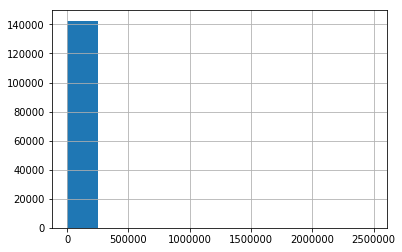

In [132]:
mhcm.hist()

This kind of worthless histogram can happen when there are outliers. 

Solution: We know there are also a lot of zeros, so let's clean those out and try to get a sense of the shape in a reasonably dense range.

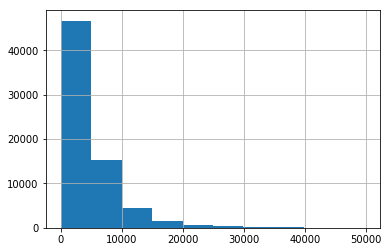

In [133]:
mhcm[(mhcm>0) & (mhcm<50000)].hist()

Ok this sort of worked, but it looks like we have a really long tail of outliers, which is going to be cause for concern. How can we effectively learn the behavior of our model when the data takes on extreme values but only infrequently?

In [134]:
(mhcm > 100000).sum()

426

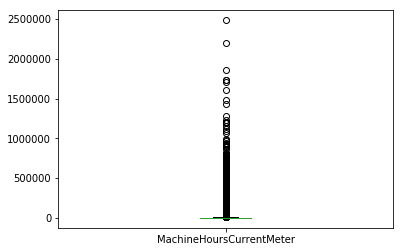

In [135]:
mhcm.plot(kind='box')


It's not obvious these things are outliers in the sense that they're just awkward data, it seems possible there are some really heavily used machines in the auction occassionally. We could consider ignoring these things, there are only a few hundred, but we'll certainly want to keep these in mind as we proceed, who knows maybe they speak a different language.

For now, let's not focus on the hours, this data is looking very difficult, so let's try to build an initial model that doesn't include it.

For equipment age, we can calculate this by taking the difference between the saledate and the year made.

In [136]:
dense_train['saledate_converted'] = pd.to_datetime(dense_train.saledate)

In [137]:
dense_train.saledate[0]  #old date version 

'11/16/2006 0:00'

In [138]:
dense_train.saledate_converted[0]   #converted date version

Timestamp('2006-11-16 00:00:00')

We are subtracking yearmade from saledate in order to find the age of the vehicle at the time of sale.

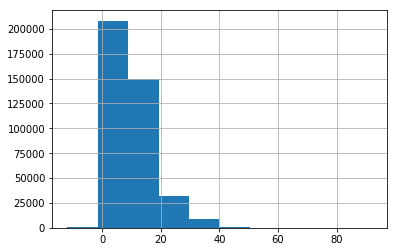

In [139]:
dense_train['equipment_age'] = dense_train.saledate_converted.dt.year - dense_train.YearMade
dense_train.equipment_age.hist()

Ok, this graph looks pretty reasonable, but maybe a few outliers on both sides:

I dont't think equipment age or anything's age can be -12. So lets fix that.


In [140]:
dense_train.equipment_age.describe()

count    401125.000000
mean         10.124841
std           7.350734
min         -12.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          92.000000
Name: equipment_age, dtype: float64

In [141]:
age = dense_train.equipment_age
(age<0).sum(), (age > 50).sum()

(1410, 196)

There are only 196 vehicles that are older than 50 years old but the actual problem is with the vehicles that are aged somehow less than 0.

Let's see what our variables look like here.

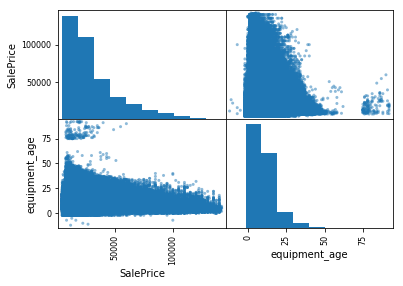

In [142]:
pd.plotting.scatter_matrix(dense_train[['SalePrice', 'equipment_age']]);

Based on the graph above, it looks like there's a bit of a collection of outliers at around 60 years old. We might be able to filter those out, or want to build another model on them.

Ok, now we return to 1. above. We want to an average price of similar vehicle. There are many ways to think about similarity including:

- Geography (look at nearby sales)
- Time (look at recent sales)
- Vehicle (look at sales that are most similar in terms of vehicle)
- Similar usage
- Similar age etc.


Ultimately choosing what similarity metric we should use is quite difficult, so for now let's try to do something easy and reasonable. What about the five most recent sales of the same modelid?

If there aren't 5 such sales of course we'll have to do something else, but let's see how big that problem is before we solve it.

In [143]:
#Set multi-level index and sort by modelid and saledate, so we can use window functions.
dense_train.sort_values(by='saledate_converted', inplace=True)

In [144]:
dense_train.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,YearMade,saledate,fiModelDesc,fiBaseModel,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,saledate_converted,equipment_age
205615,1646770,9500,1126363,8434,132,1974,1/17/1989 0:00,TD20,TD20,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,1989-01-17,15
92803,1404019,24000,1169900,7110,132,1986,1/31/1989 0:00,416,416,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Florida,BL,Backhoe Loaders,1989-01-31,3
98346,1415646,35000,1262088,3357,132,1975,1/31/1989 0:00,12G,12,Motorgrader - 130.0 to 145.0 Horsepower,Florida,MG,Motor Graders,1989-01-31,14
169297,1596358,19000,1433229,8247,132,1978,1/31/1989 0:00,644,644,Wheel Loader - 175.0 to 200.0 Horsepower,Florida,WL,Wheel Loader,1989-01-31,11
274835,1821514,14000,1194089,10150,132,1980,1/31/1989 0:00,A66,A66,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,1989-01-31,9


In [145]:
dense_train.tail()

,SalesID,SalePrice,MachineID,ModelID,datasource,YearMade,saledate,fiModelDesc,fiBaseModel,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,saledate_converted,equipment_age
393123,6260878,13500,1799594,4102,149,1996,12/30/2011 0:00,D4C,D4,"Track Type Tractor, Dozer - 75.0 to 85.0 Horse...",New York,TTT,Track Type Tractors,2011-12-30,15
397987,6288376,9750,1872596,4875,149,1996,12/30/2011 0:00,520C,520,Wheel Loader - 135.0 to 150.0 Horsepower,New York,WL,Wheel Loader,2011-12-30,15
392664,6258093,14500,1877553,3170,149,1988,12/30/2011 0:00,580K,580,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,New York,BL,Backhoe Loaders,2011-12-30,23
400458,6315563,12500,1869637,26456,149,2010,12/30/2011 0:00,L160,L160,Wheel Loader - 40.0 to 60.0 Horsepower,New York,WL,Wheel Loader,2011-12-30,1
400217,6312170,11000,1812622,9580,149,2005,12/30/2011 0:00,T190,T190,Skid Steer Loader - 1751.0 to 2201.0 Lb Operat...,New York,SSL,Skid Steer Loaders,2011-12-30,6


In [146]:
m = dense_train.groupby('ModelID')['SalePrice'].apply(lambda x: x.rolling(5).agg([np.mean]))

In [147]:
m.tail()

,mean
393123,17100.0
397987,11250.0
392664,10060.0
400458,13400.0
400217,10320.0


In [148]:
from datetime import timedelta

In [149]:
timedelta(1)

datetime.timedelta(1)

In [150]:
z = pd.concat([m, dense_train[['saledate_converted', 'ModelID', 'SalesID']]], axis=1)
z['saledate_converted'] = z.saledate_converted + timedelta(1)
#Some days will have more than 1 transaction for a particular model, take the last mean (which has most info)
z = z.groupby(['ModelID', 'saledate_converted']).apply(lambda x: x.tail(1))

In [151]:
z.head()

mean saledate_converted ModelID  SalesID
ModelID saledate_converted                                                    
1001    2007-09-13         291903      NaN         2007-09-13    1001  2210570
        2007-09-22         291323      NaN         2007-09-22    1001  2209707
        2007-11-01         291304      NaN         2007-11-01    1001  2209675
        2008-09-19         291302      NaN         2008-09-19    1001  2209672
        2008-11-19         291300  32300.0         2008-11-19    1001  2209669

In [152]:
z.head().columns

Index(['mean', 'saledate_converted', 'ModelID', 'SalesID'], dtype='object')


If we're going to use this as an input, we don't want to use an average value that could include the price of the vehicle we're trying to predict. So we'll want to shift the dates so that we can merge on the average we would have calculated the day before observing the transaction.

This is a little tricky, we need to find the closest date that is less than the transaction date and for which we have an average.

We're going to merge based on modelid and date then use fill forward to get the nearest value for any transaction (there will still be missing values).

In [158]:
near_price = pd.merge(z.drop('SalesID', axis=1), dense_train, how='outer', 
                      on=['ModelID', 'saledate_converted'])
near_price = near_price.set_index(['ModelID', 'saledate_converted']).sort_index()
g = near_price['mean'].groupby(level=0)
near_price['filled_mean_price'] = g.transform(lambda x: x.fillna(method='ffill'))

Ok, in the dataset above, the observations missing a SalesID come only from our averages table and can be dropped.

In [159]:
print(near_price.shape)
near_price.head(2)

(618626, 15)


mean  SalesID  SalePrice MachineID  datasource  \
ModelID saledate_converted                                                   
1001    2007-09-12           NaN  2210570    43000.0   1412348       136.0   
        2007-09-13           NaN      NaN        NaN       NaN         NaN   

                            YearMade        saledate fiModelDesc fiBaseModel  \
ModelID saledate_converted                                                     
1001    2007-09-12            2001.0  9/12/2007 0:00     850HLGP         850   
        2007-09-13               NaN             NaN         NaN         NaN   

                                                           fiProductClassDesc  \
ModelID saledate_converted                                                      
1001    2007-09-12          Track Type Tractor, Dozer - 85.0 to 105.0 Hors...   
        2007-09-13                                                        NaN   

                                  state ProductGroup     ProductGroupDesc  \
ModelID saledate_converted                                                  
1001    2007-09-12          Mississippi          TTT  Track Type Tractors   
        2007-09-13                  NaN          NaN                  NaN   

                            equipment_age  filled_mean_price  
ModelID saledate_converted                                    
1001    2007-09-12                    6.0                NaN  
        2007-09-13                    NaN                NaN

In [160]:
near_price = near_price[near_price.SalesID.notnull()]
near_price.shape

(401125, 15)


Ok, we're getting there. Some of our transactions in this data set will not have a 'filled mean price' because there were no previously observed transactions. Fortunately there aren't too many such observations (though this is all within the training data, so it's likely that in reality we might encounter more such cases). It's possible we could build a separate model for predicing these transactions.

In [161]:
near_price.filled_mean_price.describe()

count    379643.000000
mean      31099.690989
std       21603.158082
min        4950.000000
25%       15000.000000
50%       24300.000000
75%       40600.000000
max      140000.000000
Name: filled_mean_price, dtype: float64

What was the point of all this recent mean nonsense? Well, it was my belief that the recent mean would have predictive power of the saleprice. Was it worth it? The histogram of mean price - sale price should be instructive:

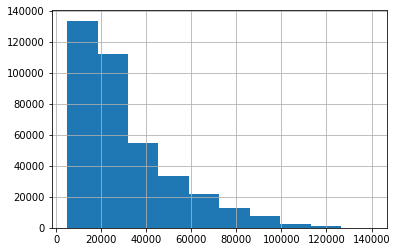

In [162]:
(near_price.filled_mean_price).hist()

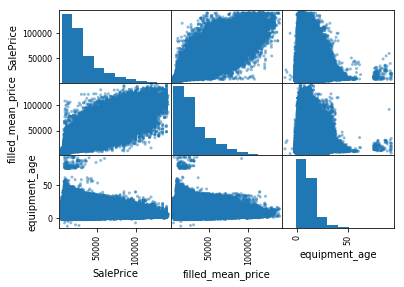

In [163]:
pd.plotting.scatter_matrix(near_price[['SalePrice', 'filled_mean_price', 'equipment_age']]);

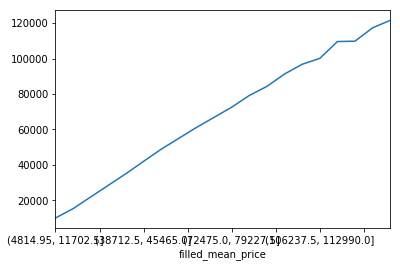

In [164]:
def percentile_plots(x, y):
    cuts = pd.cut(x, 20)
    y.groupby(cuts).mean().plot()
percentile_plots(near_price.filled_mean_price, near_price.SalePrice)

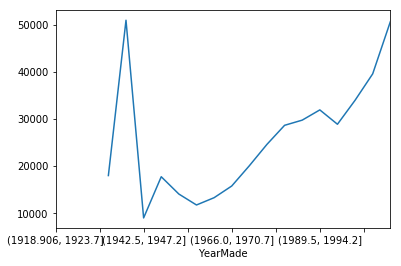

In [165]:
percentile_plots(near_price.YearMade, near_price.SalePrice)

So the mean price and sale price are definitely correlated here, it should certainly be helpful.

Ok, so we are now ready to build our first model.

I've been building in this functionality into heavy_equipment_model.py, which you should take a look at now. This uses the same ideas as above, but implements it using the Pipeline class, which is (extremely, very) helpful for preventing target leakage.

One thing we'll want to do now is set up a cross validation set. Our heldout set is future transactions, so we're going to want to choose a cv set using time as well. Let's see how we might do that.

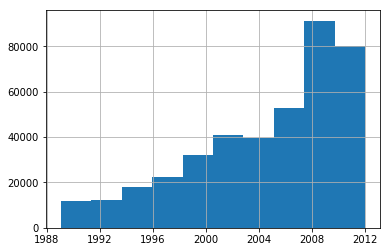

In [166]:
dense_train.saledate_converted.hist()

Ok, looks like we have more transactions recently, and we don't want to make our lives too hard by choosing a validation set that includes all of our most useful data.

In [167]:
dense_train.saledate_converted.quantile([.7, .8, .9, 1])

0.7   2008-10-22
0.8   2009-09-12
0.9   2010-10-30
1.0   2011-12-30
Name: saledate_converted, dtype: datetime64[ns]

Based on this, I would say that we probably don't want to use the usual 70/30 split, because it looks like maybe there was a change in our data collection around 2009. We've got a little less than 10% of our data represented by 2011, which isn't a huge cv data set, but I think makes sense under the circumstances. If anything, it's on the small side, so it might be reasonable to consider other datasets.

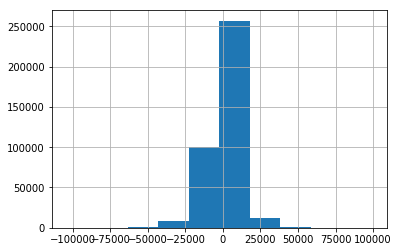

In [168]:
(near_price.filled_mean_price-near_price.SalePrice).hist()

Once we've fit a model, we're ready to iterate. A good way to prioritize future efforts would be to look at the residuals of our model and how the correlate with some of our predictors (either ones already included in the model or not). For example, if I thought state might be important, I could see if there are any significant differences in the residuals by state (using a boxplot visually, or a statistical test). If so, then I could decide to include that. We've taken the easy way out re: a lot of our variables with missing values, but we might be able to do some transformations to make them work out better.

